[View in Colaboratory](https://colab.research.google.com/github/todnewman/coe_training/blob/master/Basic_Unsupervised_Learning_Example.ipynb)

# Basic Unsupervised Learning Example

Here's an example of how we can still learn from data, even when there is no supervisory signal (target) in the data.  This dataset is fairly typical in that it is pretty unbalanced and has no target captured.  

We can determine from the [UC Irvine site](https://archive.ics.uci.edu/ml/machine-learning-databases/water-treatment/water-treatment.names) that there are 13 different classes, but this info is not captured in the data.  Once we run our code, we should be able to determine how many real classes there are.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Import a Data File and Read it Into a Pandas DataFrame

Here  we pull data from the UC Irvine open data repository. This data is useful because often it can be used to test algorithms and ML workflows.  Plus, it works well in CoLaboratory because we can download it through the firewall.

First we read the file in as a .CSV and then we print the dataframe.  You can print the dataframe by merely typing "df" only if you do it on the last line.  Otherwise, you need to print(df).  The formatting of the latter will be less pleasant than the former, BTW.

### Data description:

This dataset comes from the daily measures of sensors in a urban waste water treatment plant. The objective is to classify the operational state of the plant in order to predict faults through the state variables of the plant at each of the stages of the treatment process.  This domain has been stated as an ill-structured domain. 

###Attribute Information:

####Matrix column entries (attributes):

*  Q-E        (input flow to plant)  
*  ZN-E       (input Zinc to plant)
*  PH-E       (input pH to plant) 
*   DBO-E      (input Biological demand of oxygen to plant) 
*   DQO-E      (input chemical demand of oxygen to plant)
*   SS-E       (input suspended solids to plant)  
*   SSV-E      (input volatile supended solids to plant)
*   SED-E      (input sediments to plant) 
*   COND-E     (input conductivity to plant) 
*   PH-P       (input pH to primary settler)
*   DBO-P      (input Biological demand of oxygen to primary settler)
*   SS-P       (input suspended solids to primary settler)
*   SSV-P      (input volatile supended solids to primary settler)
*   SED-P      (input sediments to primary settler) 
*   COND-P     (input conductivity to primary settler)
*   PH-D       (input pH to secondary settler) 
*   DBO-D      (input Biological demand of oxygen to secondary settler)
*   DQO-D      (input chemical demand of oxygen to secondary settler)
*   SS-D       (input suspended solids to secondary settler)
*   SSV-D      (input volatile supended solids to secondary settler)
*   SED-D      (input sediments to secondary settler)  
*   COND-D     (input conductivity to secondary settler) 
*   PH-S       (output pH)   
*   DBO-S      (output Biological demand of oxygen)
*   DQO-S      (output chemical demand of oxygen)
*   SS-S       (output suspended solids)
*   SSV-S      (output volatile supended solids) 
*   SED-S      (output sediments) 
*   COND-S     (output conductivity)
*   RD-DBO-P   (performance input Biological demand of oxygen in primary settler)
*   RD-SS-P    (performance input suspended solids to primary settler)
*   RD-SED-P   (performance input sediments to primary settler)
*   RD-DBO-S   (performance input Biological demand of oxygen to secondary settler)
*   RD-DQO-S   (performance input chemical demand of oxygen to secondary settler)
*   RD-DBO-G   (global performance input Biological demand of oxygen)
*   RD-DQO-G   (global performance input chemical demand of oxygen)
*   RD-SS-G    (global performance input suspended solids) 
*   RD-SED-G   (global performance input sediments)
  
  

In [19]:
filename_train = 'https://archive.ics.uci.edu/ml/machine-learning-databases/water-treatment/water-treatment.data'

df_train = pd.read_csv(filename_train, parse_dates=True, header = None, encoding='ISO-8859-1')
#df_train = df_train.replace('?','')
#df_train[df_train[4].str.contains("?") == False]
df_train = df_train[~df_train.isin(['?'])]
df_train = df_train.dropna()
df_train[:5]

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
3,D-5/3/90,35023,3.50,7.9,205,588,192,65.6,4.5,2430,...,1840,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,100
8,D-11/3/90,29156,2.50,7.7,206,451,194,69.1,4.5,1249,...,1338,46.1,43.6,92.5,85.6,58.2,92.2,73.8,90.2,99.4
9,D-12/3/90,39246,2.00,7.8,172,506,200,69.0,5.0,1865,...,1616,21.2,59.7,90.8,88.4,66.1,89.0,69.0,86.5,99.6
10,D-13/3/90,42393,0.70,7.9,189,478,230,67.0,5.5,1410,...,1575,0.6,45.8,92.0,11.6,25.7,19.6,36.0,43.0,36.4
14,D-18/3/90,40923,3.50,7.6,146,329,188,57.4,2.5,1300,...,1545,32.7,33.3,90.0,82.6,61.3,87.0,71.4,78.2,99.2


## Prepare the DataFrame for Unsupervised Learning

In [0]:
'''Prep the dataset we wish to apply the model to.  There won't be a Target vector.'''
def prep_dataframe(df):
    TeamName = []
    
    Name = df.pop(0)
    
    df = df.fillna(0)
    X = np.array(df)
    return X, Name

## Simple Clustering Class - KMeans

The below is a simple and reusable approach to test various clustering techniques.  Since the wastewater treatment data is highly dimensional, I'm using Principal Component Analysis to reduce dimensionality prior to KMeans clustering.  This helps 2D visualization, but also allows us to discover hidden features.

Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! As an added benefit, each of the “new” variables after PCA are all independent of one another.

For this example, note how good the clustering looks when you look at 2 Principal Components.  It gets a bit hairier when you use 3 PC's and plot in 3D.

For K-Means clustering, the algorithm is given the number of clusters to form.  I have picked 13 because the UCI Wastewater Dataset description tells me that there are 13 classes:
### Classes
1. Normal Situation
2. Secondary settler problem -1
3. Secondary settler problem -2
4. Secondary settler problem -3
5. Normal Situation with Performance over the Mean
6. Solids overload -1
7. Secondary Settler Problem -4
8. Storm -1
9. Normal situation with low influent
10. Storm -2
11. Normal situation
12. Storm -3
13: Solids overload -2

We can determine if 13 is the best fit or not by looking at our silhouette score.



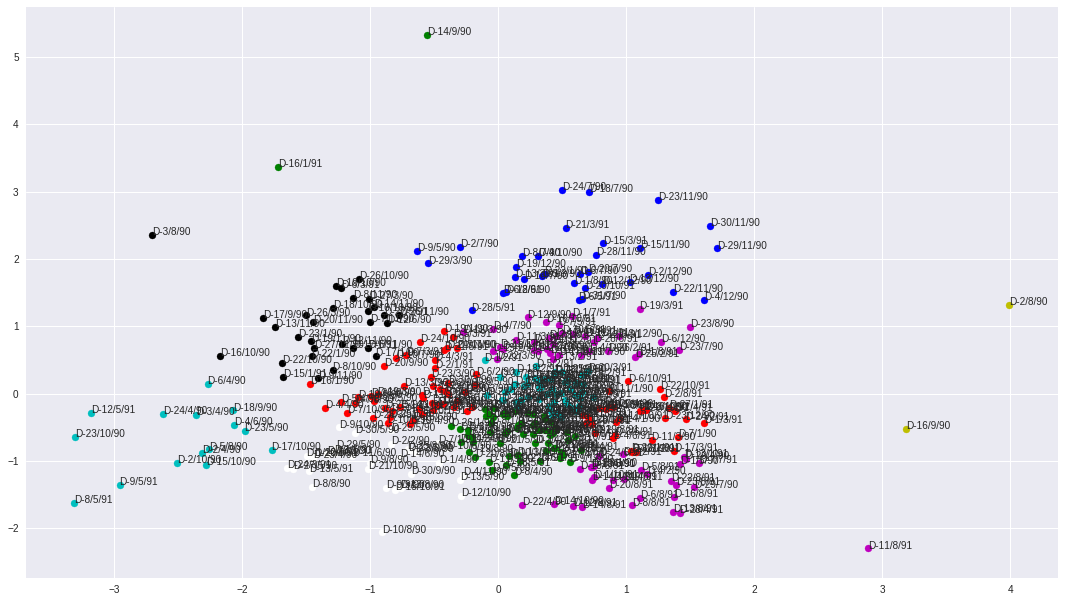

In [28]:
from itertools import cycle
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.random import RandomState
import pylab as pl
import matplotlib.pyplot as plt

class clustering:
    def __init__(self):
        df_train = pd.read_csv(filename_train, parse_dates=True, header = None, encoding='ISO-8859-1')
        df_train = df_train[~df_train.isin(['?'])]
        df_train = df_train.dropna()
        X, Names = prep_dataframe(df_train)
        self.plot(X, Names)

    def plot(self, X, Names):
        pca = PCA(n_components=2, whiten=True).fit(X)
        X_pca = pca.transform(X)
        kmeans = KMeans(n_clusters=13, random_state=RandomState(42)).fit(X_pca)
        plot_2D_2(X_pca, kmeans.labels_, ["cluster1", "cluster2", "cluster3", "cluster4", "cluster5", "cluster6",
                                          "cluster7", "cluster8", "cluster9", "cluster10", "cluster11", "cluster12", "cluster13"], Names)
    
def plot_2D_2(data, target, target_names, datapoint_names):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    colors = cycle('rgbcmykw')
    target_ids = range(len(target_names))
    for i, c, label in zip(target_ids, colors, target_names):
        ax.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    
    for i, txt in enumerate(datapoint_names):
        #print (i, txt, data[i][0], data[i][1])
        ax.annotate(txt, (data[i][0], data[i][1]))
    
if __name__ == '__main__':
    c = clustering()

## More Complex Clustering Example

The below goes through various numbers of clusters and tries to create visualizations that allow the clustering algorithm to be tuned.  This uses silhouette charts and will also show the cluster map (as does the above) in addition to plotting cluster centers.  This will show if there's enough separation between cluster centers to use these models predictively.
Again, I'm using PCA to reduce dimensionality prior to executing the KMeans algorithm.  Note how many principal components I'm choosing to reduce to this time...

Prep the dataset we wish to apply the model to.  There won't be a Target vector.
For n_clusters = 3 The average silhouette_score is : 0.30371303744426753


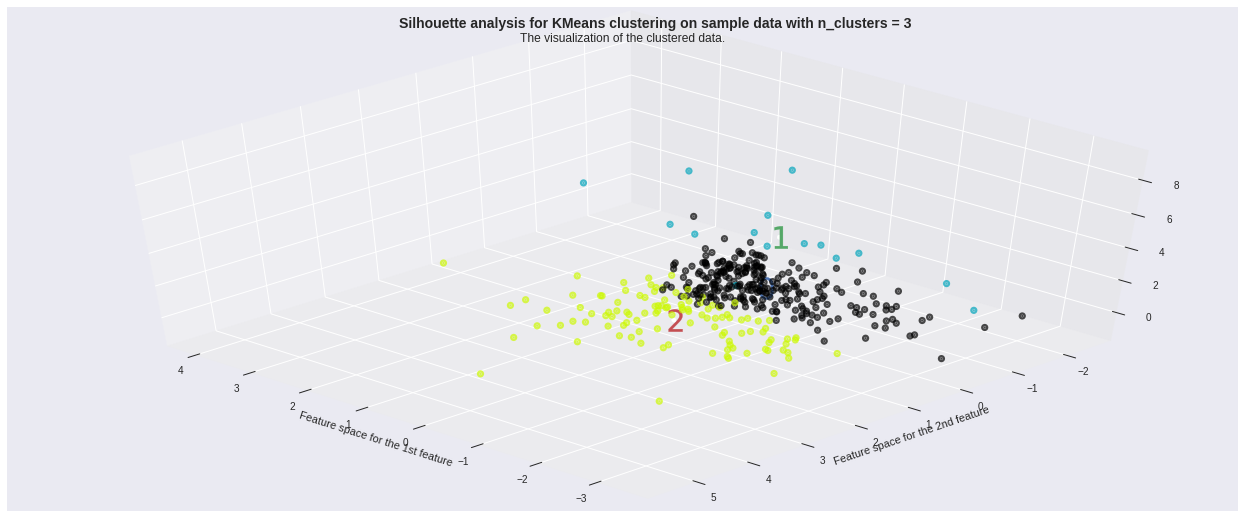

For n_clusters = 4 The average silhouette_score is : 0.31207710620113605


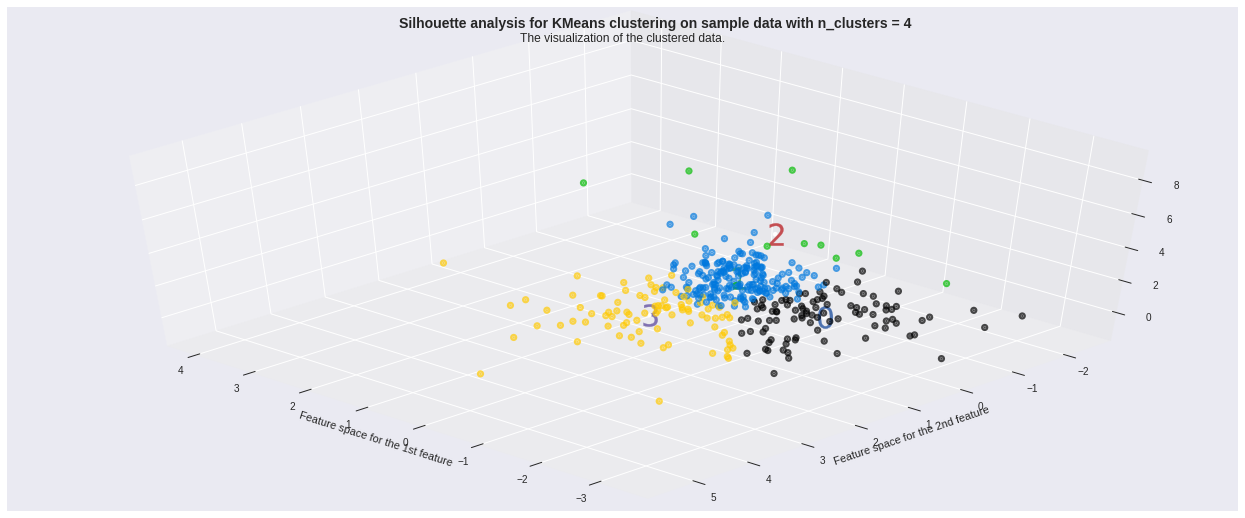

For n_clusters = 8 The average silhouette_score is : 0.28087221876662316


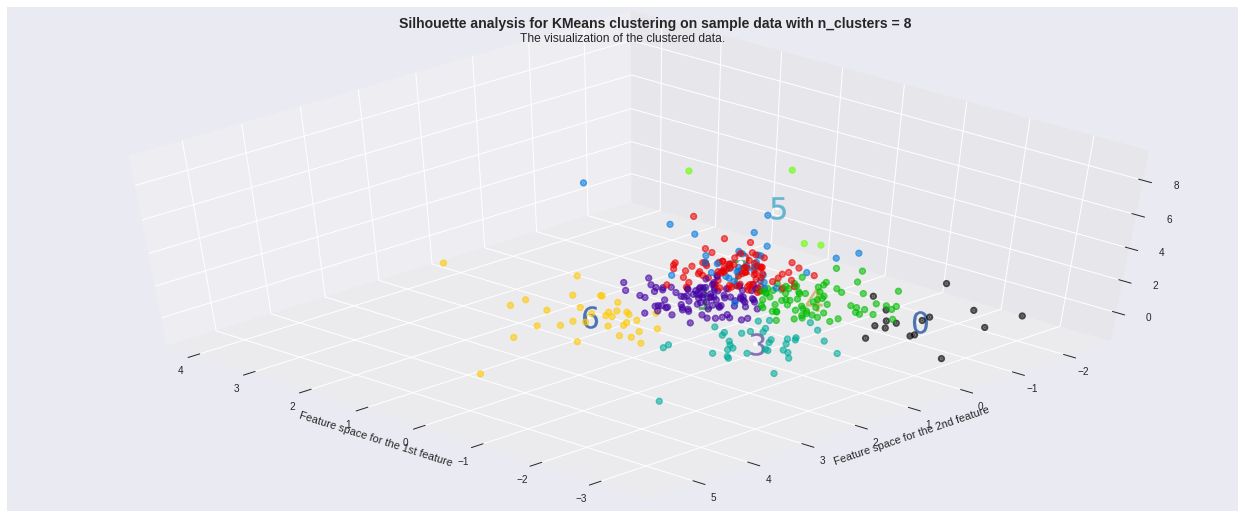

For n_clusters = 13 The average silhouette_score is : 0.26159326900866275


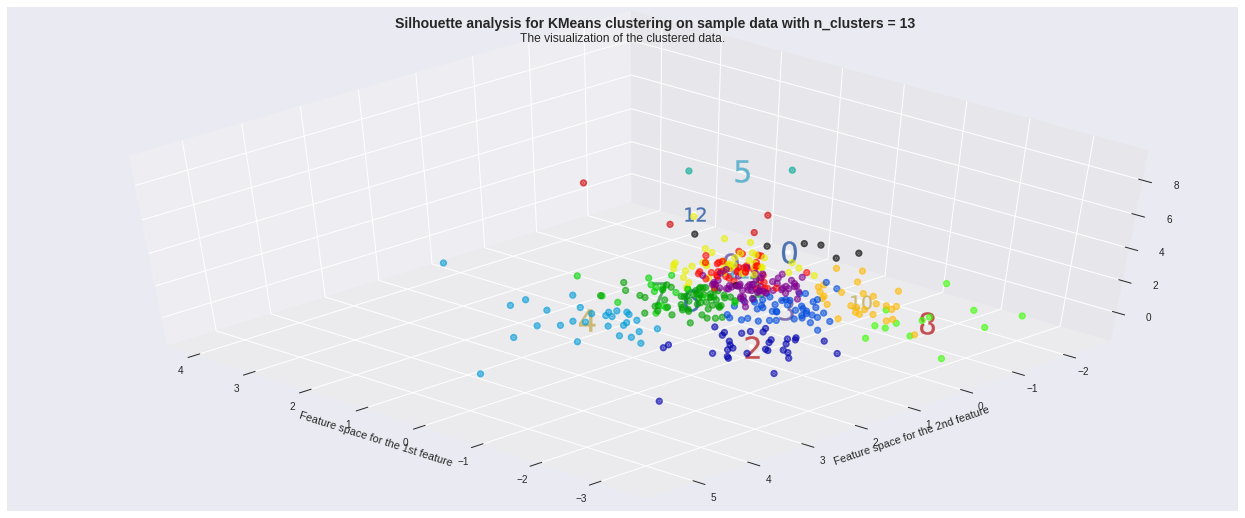

In [29]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D



print(__doc__)

df_train = pd.read_csv(filename_train, parse_dates=True, header = None, encoding='ISO-8859-1')
df_train = df_train[~df_train.isin(['?'])]
df_train = df_train.dropna()
X, Names = prep_dataframe(df_train)


range_n_clusters = [3,4,8,13]  # Define how many clusters to create.

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    
    pca = PCA(n_components=3, whiten=True).fit(X)
    X_pca = pca.transform(X)
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_pca)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    ax2 = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    #print (X[:,3])
    #print (X_pca)    
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], marker='.',  lw=5, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],centers[:, 2],
                marker='o', c="white", alpha=1)
    '''
    for i, txt in enumerate(Names):
        #print (i, txt, X_pca[i][0], X_pca[i][1], X_pca[i][2])
         ax2.text(X_pca[i,0],X_pca[i,1],X_pca[i,2],  '%s' % (txt), size=12, zorder=1, color='k') 
    '''

    #ax2.scatter(centers[:, 0], centers[:, 1],centers[:, 2],
    #           marker='o', c="white", alpha=1, s=200)


    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c[2], marker='$%d$' % i, alpha=1, s=500)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    #ax2.set_zlabel("Feature space for the 3rd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()